# Sample Analysis for Tracker Observables

Begin by importing the code, which I outsouced into `mycode.py` to keep this notebook nice and clean. 

In [1]:
from mycode import *

## Load Data and Prepare Weights

To load the data, we initialize a class `Analyzer`.
- If `inputfile` is not `None`, then the muon and neutrino spectra are just read from that file. This is the fast option. 
- Otherwise, the class loads all the data from the `/NumpyArrays` directory and compute the event weights. In this case you can save the data in an `outputfile` so that one can easily load it later on. 

In [2]:
analyser = Analyzer(prepare_nuel=False)

Prepare Data Manually
 ... found 205652 numu events in 8.99 seconds
 ... found 2944995 muon events in 116.58 seconds


Now, we can look at the statistics of muons. The following table shows the weight of individual muons in units of fb. So if this number is 0.2, then our MC statistics correspond the expected event rate for 5 fb$^{-1}$, and if it is 0.0066,then our MC statistics correspond the expected event rate for 150 fb$^{-1}$. 

In [3]:
analyser.get_muon_statistics()

121.119 : 8.905
327.154 : 2.077
524.136 : 0.58
721.13 : 0.214
924.133 : 0.189
1124.14 : 0.309
1324.14 : 0.327
1524.14 : 0.239
1724.13 : 0.145
1924.14 : 0.089
2124.14 : 0.068
2324.14 : 0.088
2521.12 : 0.085
2721.12 : 0.054
2921.12 : 0.042
3121.12 : 0.026
3321.12 : 0.012
3521.12 : 0.009


## Plot Individual Events

An individual event is characterized by a dictionary of its properties:
- `primaryEnergy` which is the energy of the incoming muon
- `zposition` indicating where the neutrino interacted (number meaningless for muons)
- `scintillator` indicating which scintillators where activated
- `calorimeter` giving the energy deposit in the calorimeter
- `hits1 ... hits4`: giving the coordinates of hits in the tracker
- `weight`: giving the event weight in units of `fb`
Let's look at one muon neutrino event:

In [4]:
print (analyser.numu_data[10])

{'primaryEnergy': 90.31156, 'zposition': 18.2, 'weight': 7.696115445752095e-05, 'scintillator': array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1]), 'calorimeter': 0.495, 'hits1': array([], dtype=float64), 'hits2': array([], dtype=float64), 'hits3': array([[ 8., 11.,  1.]]), 'hits4': array([[ 9., 10.,  1.]])}


Since the above format is a bit hard to read, we can also plot individual events. If you want to see a particular event, you can use `Analyser.display_event(event,filename)`. Alternatively, one can also use `Analyser.display_random_event(particle, requirement)` with particle being `muon`, `nu_mu` or `nu_el`. Here `requirement` adds some additional cuts on the event, when selecting it. 

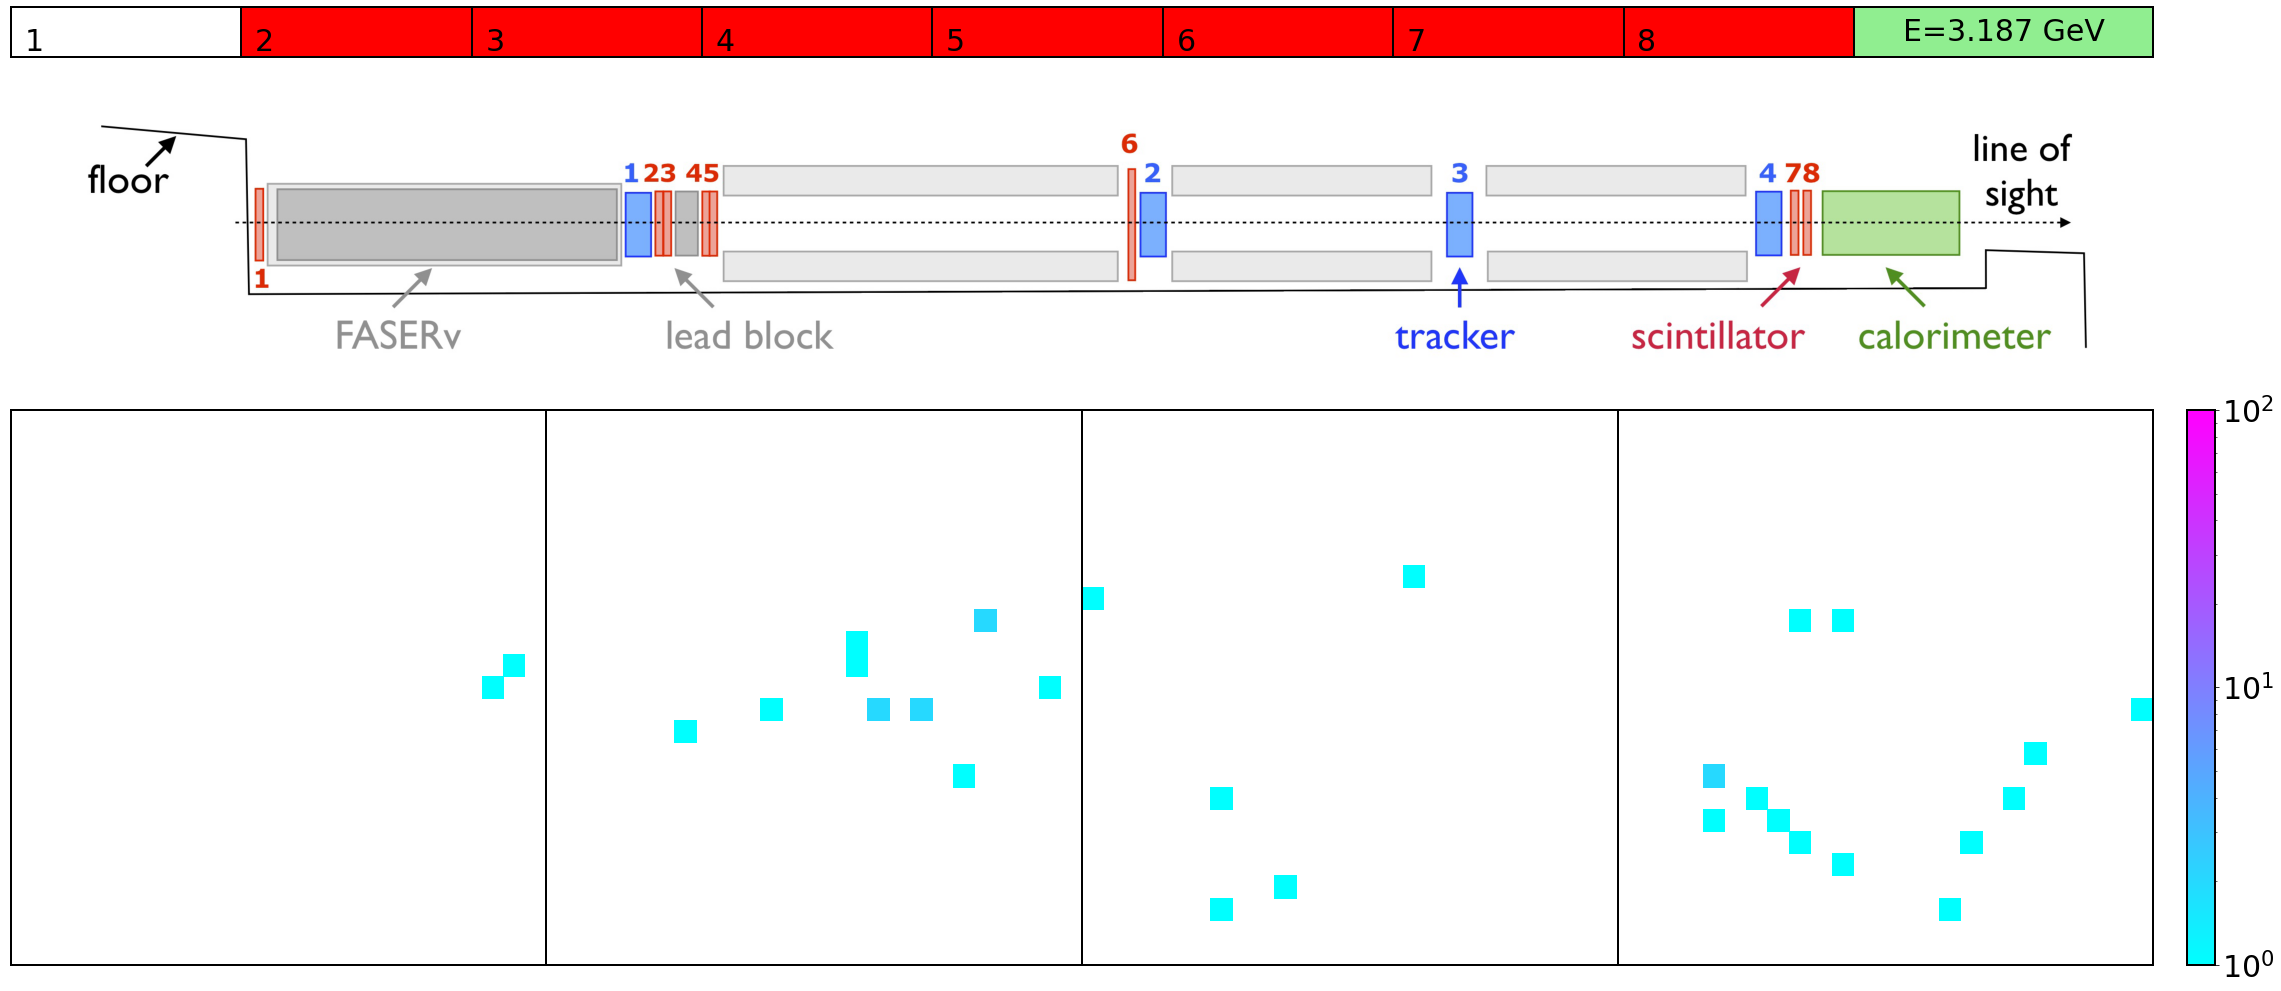

In [5]:
analyser.display_random_event(particle="numu", requirement="(event['scintillator'] == [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]).all()")

## Calorimeter Energy

###  Introduction

At first, we can define some new obseravbles via `Analyser.define_observable()`. It then loops through all events, and stores an additional property. For example here, I add the property `passed_scintillator` which is `True` when the last 7 scintillators and the calorimeter are on, and `False` otherwise. The evnts now have a property `event['passed_scintillator']` which can be used later on. 

In [6]:
analyser.define_observable(
    name="passed_scintillator", 
    definition="(event['scintillator'] == [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]).all()"
)

In the next step, let's look at some distribution. This can be done using `Analyser.get_histodata()`, which takes 
- the `particle` (so `muon`, `nu_mu` and `nu_el`)
- the `observable` which can be any property of the event which can be called as `event[observable]`
- the `requirement` which specifies the event selection.
- the `bins` which specifies the binning

The function returns the binned data as an array, with the column corresponding to the bin center, the bin value and the uncertainty. 

Below we look at the calorimeter output for all events that have the previously defined scintillator signature. 

In [7]:
bins = np.logspace(-1,3,21)
requirement = "event['passed_scintillator']==True"

data_numu = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, requirement=requirement)
data_muon = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, requirement=requirement)

This can now be plotted with the `Analyser.plot_histogram()` function.

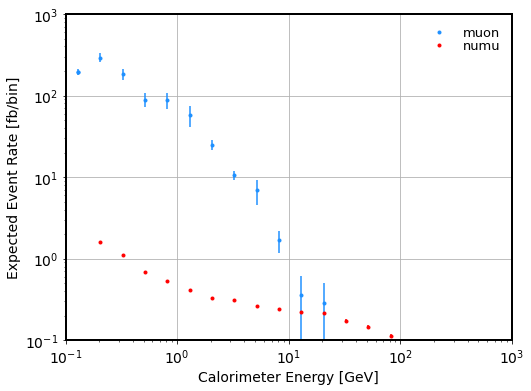

In [8]:
analyser.plot_histogram(
    dataset = [[data_muon, "dodgerblue", "muon"], [data_numu, "red", "numu"], ],
    xlabel = "Calorimeter Energy [GeV]",
    logx = True, logy = True,
    xlim = [1e-1,1e3], ylim = [1e-1,1e3],
    filename = "GeneratedPlots/Fig_ecalo.pdf",
)

### Background Analysis

Let us now dig a bit deeper and try to better understand the calorimeter deposits. At first, we split up the muon sample into different bins of primary muon energy: 

In [9]:
bins = np.logspace(-1,3,21)

data_muon_e1 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>100  and event['primaryEnergy']<300 ")
data_muon_e2 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>300  and event['primaryEnergy']<1000")
data_muon_e3 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>1000 and event['primaryEnergy']<3000")
data_muon_e4 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>3000 and event['primaryEnergy']<9000")

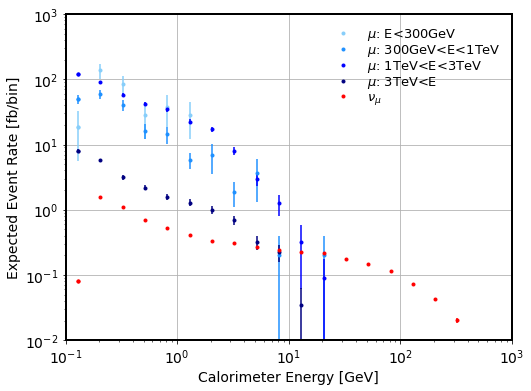

In [10]:
dataset = [
    [data_muon_e1, "lightskyblue" , "$\mu$: E<300GeV"      ],
    [data_muon_e2, "dodgerblue"   , "$\mu$: 300GeV<E<1TeV" ],
    [data_muon_e3, "blue"         , "$\mu$: 1TeV<E<3TeV"   ],
    [data_muon_e4, "navy"         , "$\mu$: 3TeV<E"        ],
    [data_numu   , "red"          , "$\\nu_\mu$"            ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Calorimeter Energy [GeV]",
    logx = True, logy = True,
    xlim = [1e-1,1e3], ylim = [1e-2,1e3],
    filename = "GeneratedPlots/Fig_ecalo_BG.pdf",
)

### Signal Analysis

Let's now look at the neutrinos. First, let's look at where they interact. Below we show the neutrino rate with / without the scintillator requirement as a function of the position. **Question: Why are there more neutrinos at the end, and not in front? Do you already require the first two scintillators to be off when storing the events?**

In [11]:
bins = np.linspace(0,150,75)
data_numu_z0 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="True")
data_numu_z1 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_numu_z2 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="event['calorimeter']>1")
data_numu_z3 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="event['passed_scintillator']==True and event['calorimeter']>1")

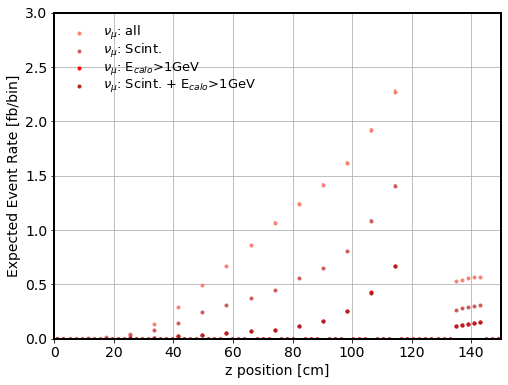

In [12]:
dataset = [
    [data_numu_z0, "salmon"       , "$\\nu_\mu$: all"                       ],
    [data_numu_z1, "indianred"    , "$\\nu_\mu$: Scint. "                   ],
    [data_numu_z2, "red"          , "$\\nu_\mu$: E$_{calo}$>1GeV"           ],
    [data_numu_z3, "firebrick"    , "$\\nu_\mu$: Scint. + E$_{calo}$>1GeV"  ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "z position [cm]",
    logx = False, logy = False,
    xlim = [0,150], ylim = [0,3],
    filename = "GeneratedPlots/Fig_zpos.pdf",
)

Let's also look at the Calorimeter energy distribution, splitted into different positions for the neutrino interaction. We see that mainly the interactions in the end of the tungsten and the lead shield give high energy deposits. 

In [13]:
bins = np.logspace(-1,3,21)

data_numu_e1 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>0  and event['zposition']<60 ")
data_numu_e2 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>60 and event['zposition']<90 ")
data_numu_e3 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>90 and event['zposition']<120")
data_numu_e4 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>120")

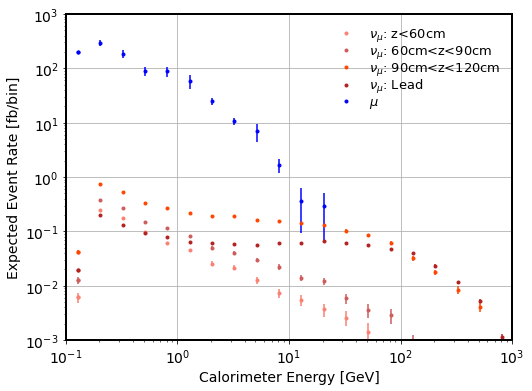

In [14]:
dataset = [
    [data_numu_e1, "salmon"       , "$\\nu_\mu$: z<60cm"      ],
    [data_numu_e2, "indianred"    , "$\\nu_\mu$: 60cm<z<90cm" ],
    [data_numu_e3, "orangered"    , "$\\nu_\mu$: 90cm<z<120cm"],
    [data_numu_e4, "firebrick"    , "$\\nu_\mu$: Lead"        ],
    [data_muon   , "blue"         , "$\mu$"                   ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Calorimeter Energy [GeV]",
    logx = True, logy = True,
    xlim = [1e-1,1e3], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_ecalo_Signal.pdf",
)

# Tracker Observables

### New Obseravbles

Let us first define a bunch of tracker obseravbles. For this, let's consider that each layer consists of a set of pixels $i$ with coordinates $(x_i, y_i)$ and a number of tracks $n_i$. We can then define the following observables for each layer
 - track multiplicity: $N = \sum_{i} n_i$

In [16]:
analyser.define_observable(name="ntracks_1", definition="0 if len(event['hits1'])==0 else sum(event['hits1'].T[2])")
analyser.define_observable(name="ntracks_2", definition="0 if len(event['hits2'])==0 else sum(event['hits2'].T[2])")
analyser.define_observable(name="ntracks_3", definition="0 if len(event['hits3'])==0 else sum(event['hits3'].T[2])")
analyser.define_observable(name="ntracks_4", definition="0 if len(event['hits4'])==0 else sum(event['hits4'].T[2])")

 - centrality: if $(X,Y) = 1/N \sum_i n_i \times (x_i,y_i)$, then the centrality is $C = \text{max}( |X|, |Y|)$. This measure of centrality corresponds to the distance to the nearest edge. 

In [18]:
for ilayer in ["1","2","3","4"]:
    #define function
    def calculate_centrality(event):
        if len(event['hits'+ilayer])==0: return -1
        pos = sum(np.array([n*x,n*y]) for x,y,n in event['hits'+ilayer]) / sum(event['hits'+ilayer].T[2])
        return max(abs(pos[0]),abs(pos[1]))
    #calculate observable
    analyser.define_observable_from_function(name="centrality_"+ilayer, function=calculate_centrality)

- spread: if $(X,Y) = 1/N \sum_i n_i \times (x_i,y_i)$ is the central point, then the spread is $S^2 = 1/N \sum_i n_i \times [(x_i,_yi)-(X,Y)]^2$. So this us the standard deviation from the center of the track distribution. 

In [75]:
for ilayer in ["1","2","3","4"]:
    #define function
    def calculate_spread(event):
        if len(event['hits'+ilayer])==0: return -1
        pos = sum(np.array([n*x,n*y]) for x,y,n in event['hits'+ilayer]) / sum(event['hits'+ilayer].T[2])
        s2 = sum(n*(x-pos[0])**2+n*(y-pos[1])**2 for x,y,n in event['hits'+ilayer]) 
        return np.sqrt(s2/sum(event['hits'+ilayer].T[2]))
    #calculate observable
    analyser.define_observable_from_function(name="spread_"+ilayer, function=calculate_spread)

### Multiplicities

Let's start by looking at the multiplicities. Let's focus on the first tracking station, which is the most interesting one. We can see that we have an excess of neutrino events with high track multiplicities. The scintillator cut certainly helps to reduce background. 

In [34]:
bins = np.logspace(0,3,16)
data_numu_n1 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_n1 = analyser.get_histodata(particle='muon', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True")

data_numu_nocut_n1 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="True")
data_muon_nocut_n1 = analyser.get_histodata(particle='muon', observable='ntracks_1', bins=bins, 
    requirement="True")

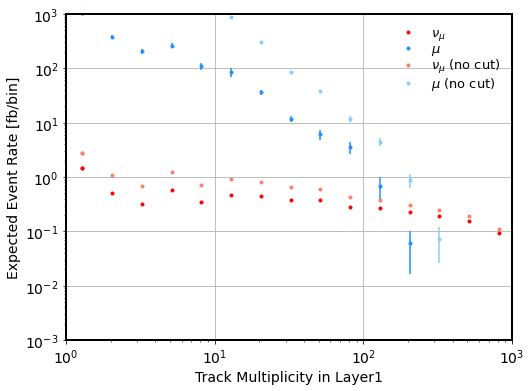

In [35]:
dataset = [
    [data_numu_n1      , "red"          , "$\\nu_\mu$"         ],
    [data_muon_n1      , "dodgerblue"   , "$\mu$"              ],
    [data_numu_nocut_n1, "salmon"       , "$\\nu_\mu$ (no cut)"],
    [data_muon_nocut_n1, "lightskyblue" , "$\mu$ (no cut)"     ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Track Multiplicity in Layer1",
    logx = True, logy = True,  xlim = [1,1000], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_ntrack_1.pdf",
)

As before, let's split up the signal into different interaction positions. As expected, the majority of the signal comes from the end of the tungsten. 

In [38]:
bins = np.logspace(0,3,16)

data_numu_n11 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>0  and event['zposition']<60 ")
data_numu_n12 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>60 and event['zposition']<90 ")
data_numu_n13 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>90 and event['zposition']<120")
data_numu_n14 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>120")

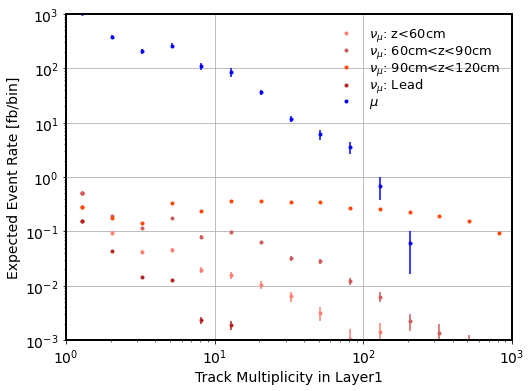

In [39]:
dataset = [
    [data_numu_n11, "salmon"       , "$\\nu_\mu$: z<60cm"      ],
    [data_numu_n12, "indianred"    , "$\\nu_\mu$: 60cm<z<90cm" ],
    [data_numu_n13, "orangered"    , "$\\nu_\mu$: 90cm<z<120cm"],
    [data_numu_n14, "firebrick"    , "$\\nu_\mu$: Lead"        ],
    [data_muon_n1 , "blue"         , "$\mu$"                   ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Track Multiplicity in Layer1",
    logx = True, logy = True,
    xlim = [1,1e3], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_ntrack1_Signal.pdf",
)

### Centrality

Let's now look at the centrality measures. We focus on the first two layers, the others are less interesting. However, we note that there is no big difference. 

In [51]:
bins = np.linspace(0,13,14)
data_numu_cc1 = analyser.get_histodata(particle='numu', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_cc1 = analyser.get_histodata(particle='muon', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_numu_cc2 = analyser.get_histodata(particle='numu', observable='ccentrality_2', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_cc2 = analyser.get_histodata(particle='muon', observable='ccentrality_2', bins=bins, 
    requirement="event['passed_scintillator']==True")

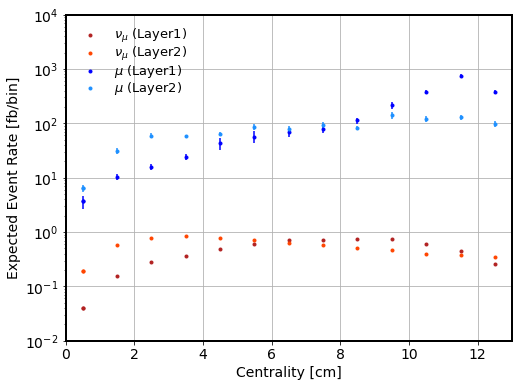

In [79]:
dataset = [
    [data_numu_cc1, "firebrick"    , "$\\nu_\mu$ (Layer1)" ],
    [data_numu_cc2, "orangered"    , "$\\nu_\mu$ (Layer2)" ],
    [data_muon_cc1, "blue"         , "$\mu$ (Layer1)"      ],
    [data_muon_cc2, "dodgerblue"   , "$\mu$ (Layer2)"      ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Centrality [cm]",
    logx = False, logy = True,  xlim = [0,13], ylim = [1e-2,1e4],
    filename = "GeneratedPlots/Fig_centrality.pdf",
)

To suppress backgrounds, let us look at the centrality distribution for various different bins of track multiplicities. It's hard to say if the centrality helps at high multiplicities. Maybe it helps a bit in the context of a multi-variet analysis.  

In [104]:
bins = np.linspace(0,10,21)
data_numu_c11 = analyser.get_histodata(particle='numu', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_muon_c11 = analyser.get_histodata(particle='muon', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_numu_c12 = analyser.get_histodata(particle='numu', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100")
data_muon_c12 = analyser.get_histodata(particle='muon', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100")
data_numu_c13 = analyser.get_histodata(particle='numu', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")
data_muon_c13 = analyser.get_histodata(particle='muon', observable='ccentrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")

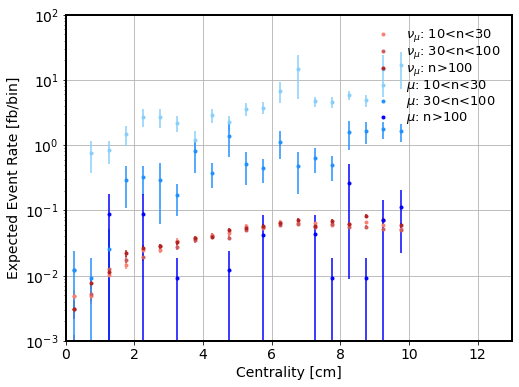

In [106]:
dataset = [
    [data_numu_c11, "salmon"      , "$\\nu_\mu$: 10<n<30"  ],
    [data_numu_c12, "indianred"   , "$\\nu_\mu$: 30<n<100" ],
    [data_numu_c13, "firebrick"   , "$\\nu_\mu$: n>100"    ],
    [data_muon_c11, "lightskyblue", "$\mu$: 10<n<30"       ],
    [data_muon_c12, "dodgerblue"  , "$\mu$: 30<n<100"      ],
    [data_muon_c13, "blue"        , "$\mu$: n>100"         ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Centrality [cm]",
    logx = False, logy = True,  xlim = [0,13], ylim = [1e-3,1e2],
    filename = "GeneratedPlots/Fig_centrality_ntrack.pdf",
)

### Spread

Let's now look at the spread. We can see that, in the first layer, the signal is more concentrated at low spreads. In the second layer (and also the third and fourth) the spread is bigger. Overall, the background is much larger. 

In [98]:
bins = np.linspace(0,15,31)
data_numu_s1 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_s1 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_numu_s2 = analyser.get_histodata(particle='numu', observable='spread_2', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_s2 = analyser.get_histodata(particle='muon', observable='spread_2', bins=bins, 
    requirement="event['passed_scintillator']==True")

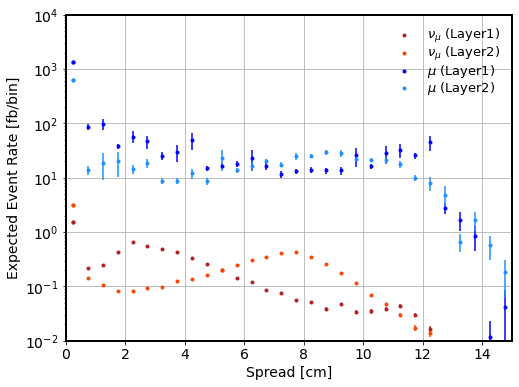

In [99]:
dataset = [
    [data_numu_s1, "firebrick"    , "$\\nu_\mu$ (Layer1)" ],
    [data_numu_s2, "orangered"    , "$\\nu_\mu$ (Layer2)" ],
    [data_muon_s1, "blue"         , "$\mu$ (Layer1)"      ],
    [data_muon_s2, "dodgerblue"   , "$\mu$ (Layer2)"      ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Spread [cm]",
    logx = False, logy = True,  xlim = [0,15], ylim = [1e-2,1e4],
    filename = "GeneratedPlots/Fig_centrality.pdf",
)

To suppress backgrounds, let us look at the spread distribution for various different bins of track multiplicities. We can see that at the high-multiplicity bins, the spread can help to further single out the signal.  

In [100]:
bins = np.linspace(0,15,31)
data_numu_s11 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_muon_s11 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_numu_s12 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100" )
data_muon_s12 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100")
data_numu_s13 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")
data_muon_s13 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")

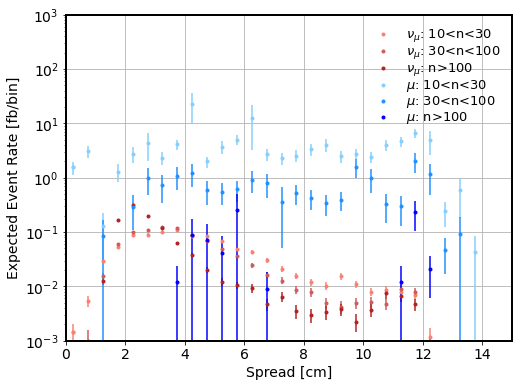

In [101]:
dataset = [
    [data_numu_s11, "salmon"      , "$\\nu_\mu$: 10<n<30"  ],
    [data_numu_s12, "indianred"   , "$\\nu_\mu$: 30<n<100" ],
    [data_numu_s13, "firebrick"   , "$\\nu_\mu$: n>100"    ],
    [data_muon_s11, "lightskyblue", "$\mu$: 10<n<30"       ],
    [data_muon_s12, "dodgerblue"  , "$\mu$: 30<n<100"      ],
    [data_muon_s13, "blue"        , "$\mu$: n>100"         ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Spread [cm]",
    logx = False, logy = True,  xlim = [0,15], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_spread_ntrack.pdf",
)

### 2D Distributions (work in progress) 

In [142]:
def plot_2dhistogram(particles, observable1, observable2, bins1, bins2, vmin, vmax, requirement=None,
        xlabel="Observable1", ylabel="Observable2", logx=False, logy=False, filename=None ):
    
    # prepare plot
    matplotlib.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(8*len(particles),6))
        
    # loop over particles
    for iparticle,particle in enumerate(particles):
        
        #check particle type, assign data:
        allparticles = {'muon': analyser.muon_data, 'numu': analyser.numu_data, 'nuel': analyser.nuel_data}
        if particle in allparticles.keys(): data = allparticles[particle]
        else: print ("Error: particle must be either 'muon', 'numu' or 'nuel'")
        
        # loop through events
        selected_data = []
        for event in data:
            if eval(requirement) == False: continue
            value1 = event[observable1]
            value2 = event[observable2]
            weight = event['weight']
            selected_data.append([value1, value2, weight])
        selected_data = np.array(selected_data)
        
        # plot binned data
        ax = plt.subplot(1,len(particles),iparticle+1)
        h = ax.hist2d(
            selected_data.T[0], selected_data.T[1], weights=selected_data.T[2],
            bins=[bins1,bins2], range=[[bins1[0], bins1[-1]],[bins2[0], bins2[-1]]],
            norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax),cmap='jet',
        )
        plt.colorbar(h[3])

        # finalize       
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)  
        if logx: ax.set_xscale("log")
        if logy: ax.set_yscale("log")
    if filename is not None: fig.savefig(filename)
    plt.show()

**Make 3 plots: S, B and S/B**

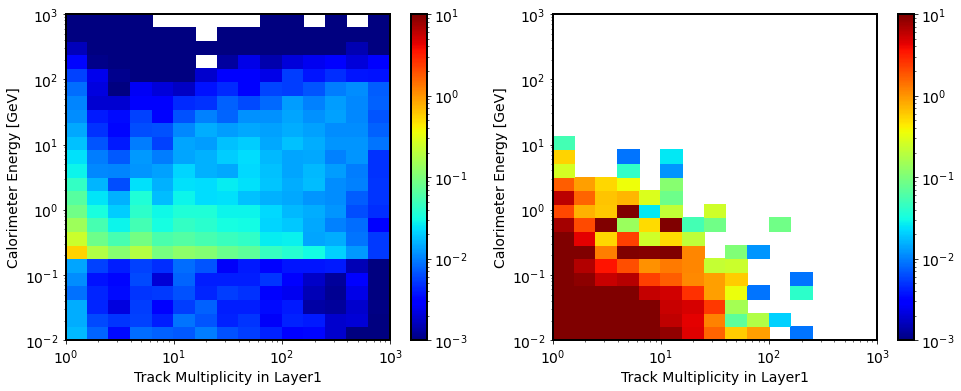

In [143]:
bins_energy=np.logspace(-2,3,25)
bins_ntrack=np.logspace(0,3,16)
plot_2dhistogram(
    particles=['numu', 'muon'], 
    observable1='ntracks_1',bins1=bins_ntrack, 
    observable2="calorimeter", bins2=bins_energy,
    requirement="event['passed_scintillator']==True",
    vmin=1e-3, vmax=1e1,
    logx = True, logy = True,
    xlabel="Track Multiplicity in Layer1", ylabel="Calorimeter Energy [GeV]"
)

**Make plots: E vs N, E vs C, E vs S, C vs S**